In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-delays-dataset/flight_delays.csv


In [5]:
df = pd.read_csv("/kaggle/input/flight-delays-dataset/flight_delays.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   FlightID    Airline  FlightNumber Origin Destination ScheduledDeparture  \
0         1     United          4558    ORD         MIA   2024-09-01 08:11   
1         2      Delta          8021    LAX         MIA   2024-09-01 10:25   
2         3  Southwest          7520    DFW         SFO   2024-09-01 16:53   
3         4      Delta          2046    ORD         BOS   2024-09-01 14:44   
4         5      Delta          6049    LAX         SEA   2024-09-01 01:51   

    ActualDeparture  ScheduledArrival     ActualArrival  DelayMinutes  \
0  2024-09-01 08:30  2024-09-01 12:11  2024-09-01 12:19             8   
1  2024-09-01 10:41  2024-09-01 13:25  2024-09-01 13:27             2   
2  2024-09-01 17:05  2024-09-01 17:53  2024-09-01 18:07            14   
3  2024-09-01 15:04  2024-09-01 18:44  2024-09-01 18:34           -10   
4  2024-09-01 02:08  2024-09-01 05:51  2024-09-01 06:15            24   

           DelayReason  Cancelled  Diverted AircraftType TailNumber  Distance  
0           

In [6]:
# Fill missing values in 'DelayReason' with 'Unknown'
df['DelayReason'].fillna('NaN', inplace=True)
print(df.isnull().sum())

/tmp/ipykernel_36/844208206.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DelayReason'].fillna('NaN', inplace=True)


FlightID              0
Airline               0
FlightNumber          0
Origin                0
Destination           0
ScheduledDeparture    0
ActualDeparture       0
ScheduledArrival      0
ActualArrival         0
DelayMinutes          0
DelayReason           0
Cancelled             0
Diverted              0
AircraftType          0
TailNumber            0
Distance              0
dtype: int64


In [7]:
# Convert date columns to datetime format
df['ScheduledDeparture'] = pd.to_datetime(df['ScheduledDeparture'])
df['ActualDeparture'] = pd.to_datetime(df['ActualDeparture'])
df['ScheduledArrival'] = pd.to_datetime(df['ScheduledArrival'])
df['ActualArrival'] = pd.to_datetime(df['ActualArrival'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   FlightID            int64         
 1   Airline             object        
 2   FlightNumber        int64         
 3   Origin              object        
 4   Destination         object        
 5   ScheduledDeparture  datetime64[ns]
 6   ActualDeparture     datetime64[ns]
 7   ScheduledArrival    datetime64[ns]
 8   ActualArrival       datetime64[ns]
 9   DelayMinutes        int64         
 10  DelayReason         object        
 11  Cancelled           bool          
 12  Diverted            bool          
 13  AircraftType        object        
 14  TailNumber          object        
 15  Distance            int64         
dtypes: bool(2), datetime64[ns](4), int64(4), object(6)
memory usage: 190.0+ MB
None


In [8]:
# Feature extraction
df['DepartureHour'] = df['ScheduledDeparture'].dt.hour
df['ArrivalHour'] = df['ScheduledArrival'].dt.hour
df['DayOfWeek'] = df['ScheduledDeparture'].dt.dayofweek

# Limit the dataset to 15,000 entries
df = df.sample(n=15000, random_state=42)

# Drop columns not needed for prediction
df.drop(columns=['FlightID', 'ScheduledDeparture', 'ActualDeparture', 'ScheduledArrival', 'ActualArrival', 'TailNumber'], inplace=True)
df.head()

,Airline,FlightNumber,Origin,Destination,DelayMinutes,DelayReason,Cancelled,Diverted,AircraftType,Distance,DepartureHour,ArrivalHour,DayOfWeek
864482,United,3,DFW,SFO,19,Air Traffic Control,True,False,Boeing 777,2553,20,22,6
866372,Delta,6180,DFW,SFO,-1,NaN,True,False,Boeing 777,1936,3,6,6
546108,United,8536,ATL,SEA,3,Air Traffic Control,True,True,Boeing 737,216,20,22,6
1344518,Delta,2483,ATL,MIA,29,Air Traffic Control,True,False,Boeing 777,2809,21,23,6
1304682,United,7291,LAX,SFO,-1,NaN,False,False,Boeing 737,495,17,22,6


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Encode categorical variables
categorical_features = ['Airline', 'Origin', 'Destination', 'DelayReason', 'AircraftType']
numeric_features = ['FlightNumber', 'Distance', 'DepartureHour', 'ArrivalHour', 'DayOfWeek']
boolean_features = ['Cancelled', 'Diverted']


# Define preprocessing for categorical and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('bool', 'passthrough', boolean_features)
    ]
)

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = df.drop('DelayMinutes', axis=1)
y = df['DelayMinutes']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the preprocessor on the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = preprocessor.transform(X_test)


In [11]:
print("Sample of processed training data:")
print(X_train_processed[:5])
print("Sample of y_train:")
print(y_train.head())

Sample of processed training data:
[[ 0.2282109  -0.72169223 -0.79675492 -0.65350362  0.          0.
   1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          1.
   0.          1.          0.          0.          0.          0.
   0.          1.          0.          1.        ]
 [ 1.31255482 -0.56517996 -0.07298058  0.7915815   0.          0.
   1.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          1.          0.          0.
   0.          1.          0.          0.        ]
 [ 0.78290254 -1.44690559 -1.37577439 -0.79801213  0.          0.
   1.          0.          0.          0.          0.          0.
   1.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   1.          0.          0.          1.        ]
 [-1.09296375  0.057

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

# Create the SVR model pipeline
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Train the model
svr_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['FlightNumber', 'Distance',
                                                   'DepartureHour',
                                                   'ArrivalHour',
                                                   'DayOfWeek']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Origin',
                                                   'Destination', 'DelayReason',
                                                   'AircraftType']),
                                                 ('bool', 'passthrough',
                                                  ['Cancelled', 'Diverted'])])),
                ('regressor', SVR())])

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_pred_svr = svr_pipeline.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR MSE: {mse_svr:.2f}")
print(f"SVR R2 Score: {r2_svr:.2f}")

SVR MSE: 60.79
SVR R2 Score: 0.57


In [14]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.01, 0.1, 1],
    'regressor__gamma': ['scale', 'auto']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best SVR MSE: {mse_best:.2f}")
print(f"Best SVR R2 Score: {r2_best:.2f}")


Best parameters found:  {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__gamma': 'auto'}
Best SVR MSE: 59.01
Best SVR R2 Score: 0.58


UNSUPERVISED LEARNING

In [15]:
# Import necessary libraries for K-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [33]:
# Elbow method to find the optimal number of clusters
inertia = []
sil_scores = []
K = range(2, 200, 20)

for k in K:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=10)
    kmeans.fit(X_train_processed)
    inertia.append(kmeans.inertia_)
    sil_score = silhouette_score(X_train_processed, kmeans.labels_)
    sil_scores.append(sil_score)


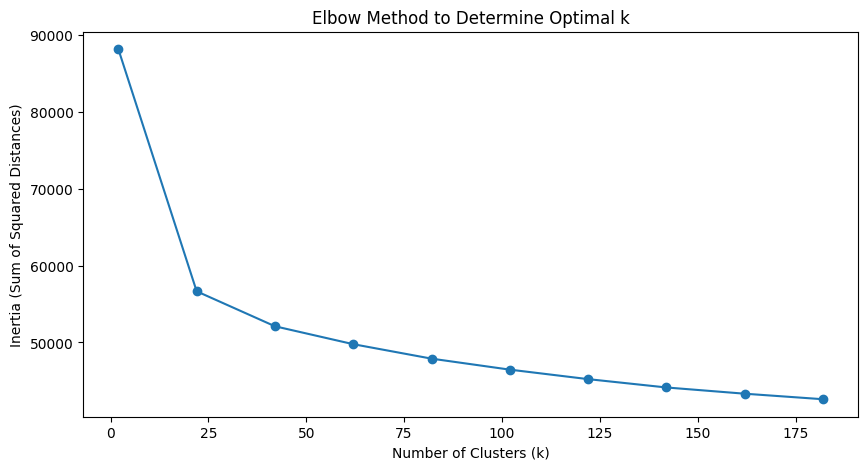

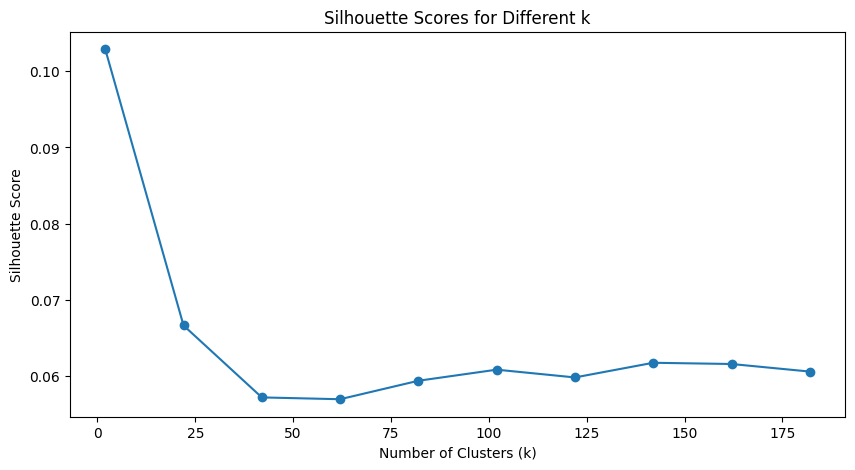

In [34]:
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(K, sil_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [35]:
# Choose the optimal number of clusters
optimal_k = 25

# Train the final K-means model
kmeans_final = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42, n_init=10)
kmeans_final.fit(X_train_processed)

KMeans(n_clusters=25, n_init=10, random_state=42)

In [36]:
# Evaluate the clustering performance using Silhouette Score
final_sil_score = silhouette_score(X_train_processed, kmeans_final.labels_)
print(f"Final Silhouette Score: {final_sil_score}")

Final Silhouette Score: 0.06343293574238575
